In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1393caac5aebd83cc77f4829a9192294ef86c5b5502a05b3d38e26703a10f4c1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('BDA Project')\
    .getOrCreate()

In [ ]:
from pyspark.sql.functions import col

Sales= spark.read.csv("/content/sample_data/Sales.csv", inferSchema= True,header=True)
Sales.show(10)
Sales.printSchema()
Sales = Sales.dropDuplicates()

# Drop rows with null values in any column
Sales = Sales.dropna()

# Show the resulting DataFrame
Sales.show()

+--------+--------+----------------+----------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+
|RegionID|SizeRank|      RegionName|RegionType|StateName|3/31/2018|4/30/2018|5/31/2018|6/30/2018|7/31/2018|8/31/2018|9/30/2018|10/31/2018|11/30/2018|12/31/2018|1/31/2019|2/28/2019|3/31/2019|4/30/2019|5/31

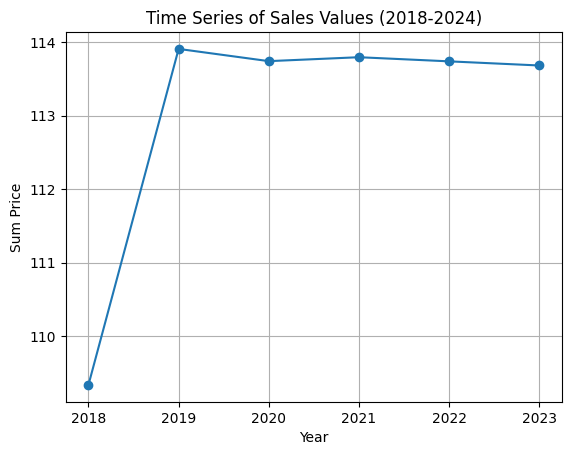

In [ ]:
from pyspark.sql.functions import col, explode, expr, to_date, year

date_columns = Sales.columns[5:]
df_long = Sales.select(
    col("RegionID"), col("SizeRank"), col("RegionName"), col("RegionType"), col("StateName"),
    explode(expr("map(" + ", ".join([f"'{c}', {c}" for c in date_columns]) + ")")).alias("date", "price")
)

df_long = df_long.withColumn("date", to_date(col("date"), "M/d/yyyy"))

# Extract year from the date column
df_long = df_long.withColumn("year", year("date"))

# Scale up the price values by multiplying them by 1000
df_long = df_long.withColumn("price", col("price") * 1000)

# Filter the DataFrame to include years between 2018 and 2023
df_filtered = df_long.filter((col("year") >= 2018) & (col("year") <= 2023))

# Group by year and calculate the sum of prices
time_series = df_filtered.groupBy("year").sum("price").orderBy("year")

# Collect the results to the driver node
time_series_data = time_series.collect()

# Convert the result to a Pandas DataFrame for plotting
import pandas as pd
time_series_df = pd.DataFrame(time_series_data, columns=["year", "sum_price"])

# Plot the time series
import matplotlib.pyplot as plt

plt.plot(time_series_df["year"], time_series_df["sum_price"], marker='o')
plt.xlabel("Year")
plt.ylabel("Sum Price")
plt.title("Time Series of Sales Values (2018-2024)")
plt.grid(True)
plt.show()


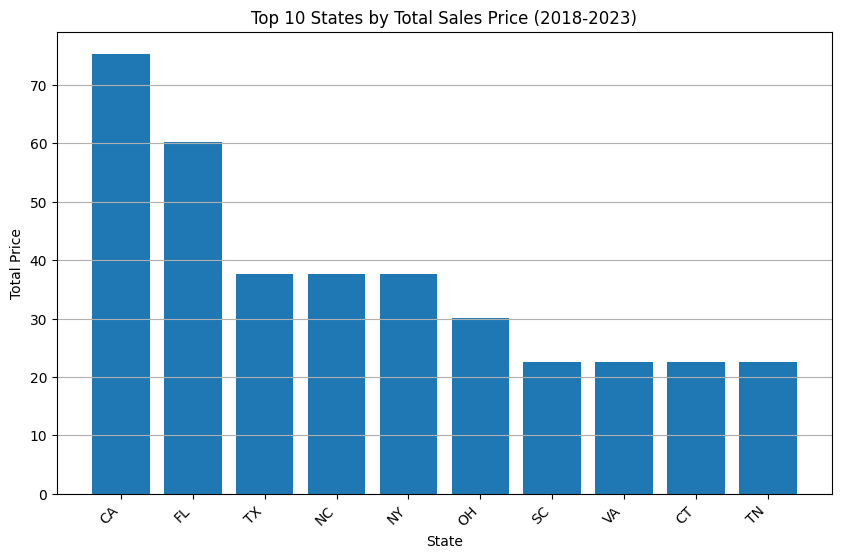

In [ ]:
from pyspark.sql import functions as F

# Group by StateName and calculate the sum of prices
state_sum_prices = df_filtered.groupBy("StateName").agg(F.sum("price").alias("total_price"))

# Sort the states based on the total sum of prices
top_10_states = state_sum_prices.orderBy(F.desc("total_price")).limit(10)

# Collect the results to the driver node
top_10_states_data = top_10_states.collect()

# Convert the result to a Pandas DataFrame for plotting
top_10_states_df = pd.DataFrame(top_10_states_data, columns=["StateName", "total_price"])

# Plot the top 10 states by sum of prices
plt.figure(figsize=(10, 6))
plt.bar(top_10_states_df["StateName"], top_10_states_df["total_price"])
plt.xlabel("State")
plt.ylabel("Total Price")
plt.title("Top 10 States by Total Sales Price (2018-2023)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [ ]:
#Prediction

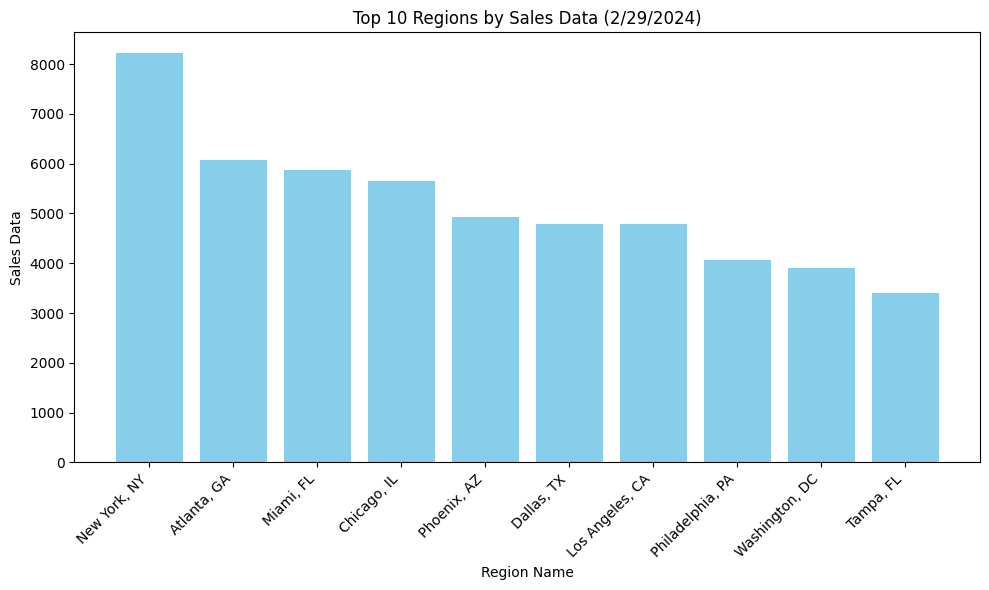

In [ ]:
import matplotlib.pyplot as plt

# Selecting the top 10 entries based on the last date (2/29/2024)
top_10_sales = Sales.orderBy("2/29/2024", ascending=False).limit(10)

# Extracting the region names and their corresponding sales data for plotting
region_names = top_10_sales.select("RegionName").rdd.flatMap(lambda x: x).collect()
sales_data = top_10_sales.select("2/29/2024").rdd.flatMap(lambda x: x).collect()

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(region_names, sales_data, color='skyblue')
plt.xlabel('Region Name')
plt.ylabel('Sales Data')
plt.title('Top 10 Regions by Sales Data (2/29/2024)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


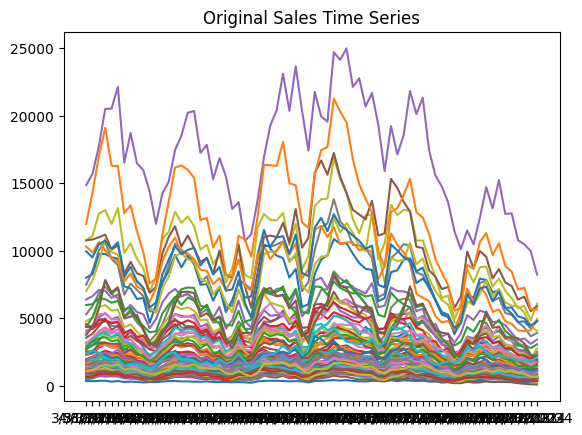

ADF Statistic: -6.143098658007421
p-value: 7.884297832319863e-08
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

sales_df = Sales.toPandas()
sales_data = sales_df.drop(columns=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'])
sales_ts = sales_data.T

def stationarity_check(timeseries):
    result = adfuller(timeseries.values.flatten())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Plot the original time series
plt.plot(sales_ts)
plt.title('Original Sales Time Series')
plt.show()

# Check stationarity
stationarity_check(sales_ts)


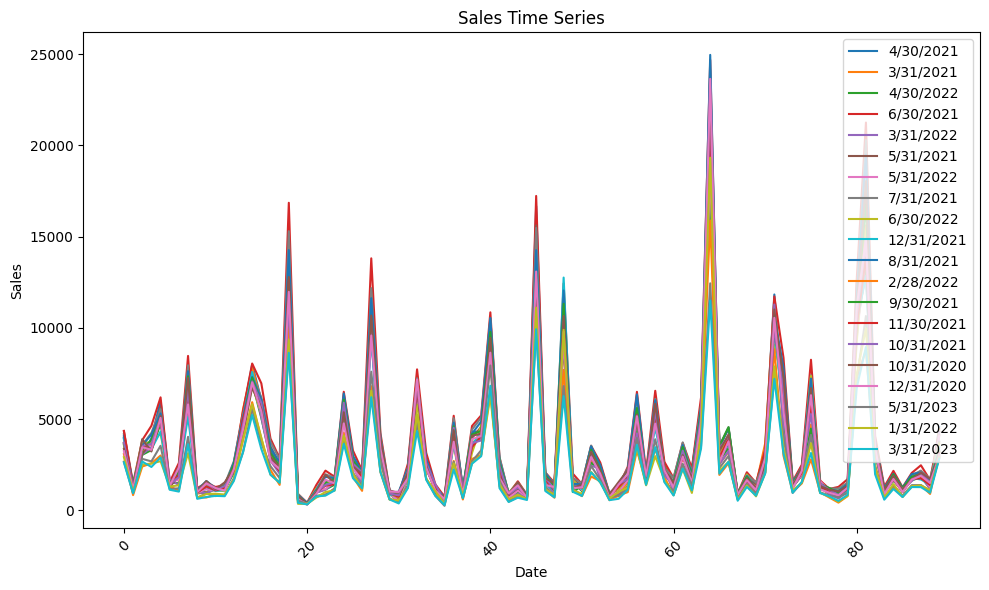

Stationarity Check for 4/30/2021:
ADF Statistic: -7.6103104604350085
p-value: 2.2643386752741678e-11
Critical Values:
	1%: -3.506944401824286
	5%: -2.894989819214876
	10%: -2.584614550619835

Stationarity Check for 3/31/2021:
ADF Statistic: -7.581067830967871
p-value: 2.6810872588057973e-11
Critical Values:
	1%: -3.506944401824286
	5%: -2.894989819214876
	10%: -2.584614550619835

Stationarity Check for 4/30/2022:
ADF Statistic: -7.723975368302705
p-value: 1.1723164005682859e-11
Critical Values:
	1%: -3.506944401824286
	5%: -2.894989819214876
	10%: -2.584614550619835

Stationarity Check for 6/30/2021:
ADF Statistic: -7.6493912338934
p-value: 1.8062098574925302e-11
Critical Values:
	1%: -3.506944401824286
	5%: -2.894989819214876
	10%: -2.584614550619835

Stationarity Check for 3/31/2022:
ADF Statistic: -7.692485581528851
p-value: 1.4072111161593289e-11
Critical Values:
	1%: -3.506944401824286
	5%: -2.894989819214876
	10%: -2.584614550619835

Stationarity Check for 5/31/2021:
ADF Statisti

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Assuming sales_ts is your time series data

def stationarity_check(time_series):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    """
    result = adfuller(time_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# Selecting the top 20 entries based on the latest date
top_20_sales = sales_ts.sort_values(by=sales_ts.columns[-1], ascending=False).iloc[:20]

# Plot the top 20 time series
plt.figure(figsize=(10, 6))
for index, row in top_20_sales.iterrows():
    plt.plot(row, label=index)

plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check stationarity for the top 20 time series
for index, row in top_20_sales.iterrows():
    print(f"Stationarity Check for {index}:")
    stationarity_check(row)
    print()


<Figure size 1000x400 with 0 Axes>

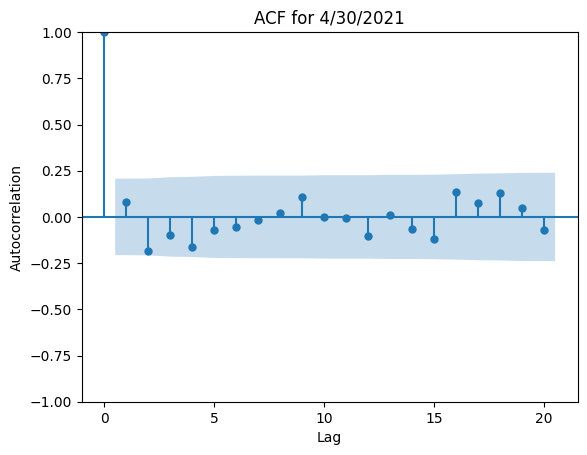

<Figure size 1000x400 with 0 Axes>

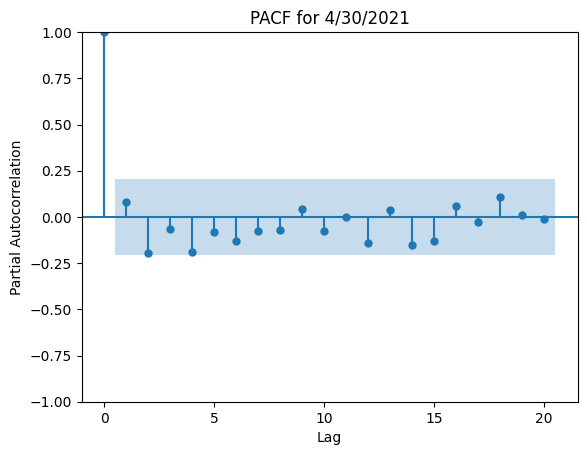

<Figure size 1000x400 with 0 Axes>

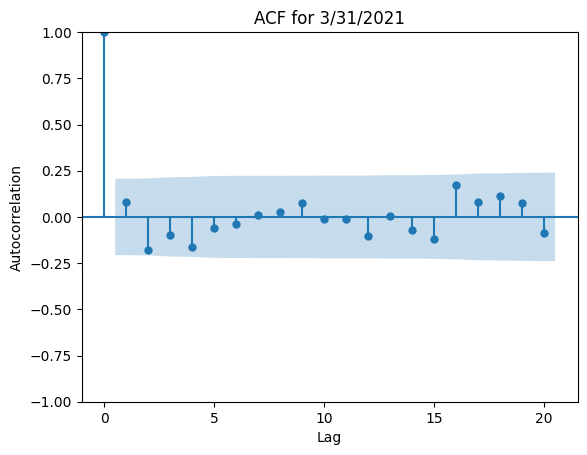

<Figure size 1000x400 with 0 Axes>

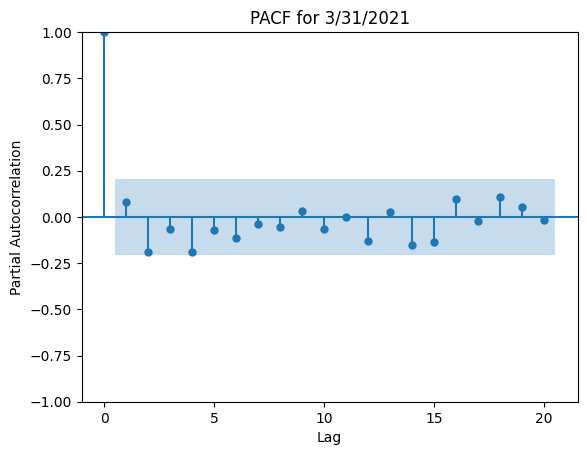

<Figure size 1000x400 with 0 Axes>

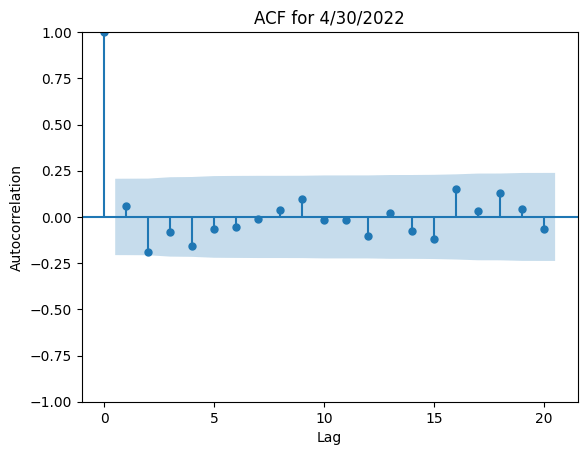

<Figure size 1000x400 with 0 Axes>

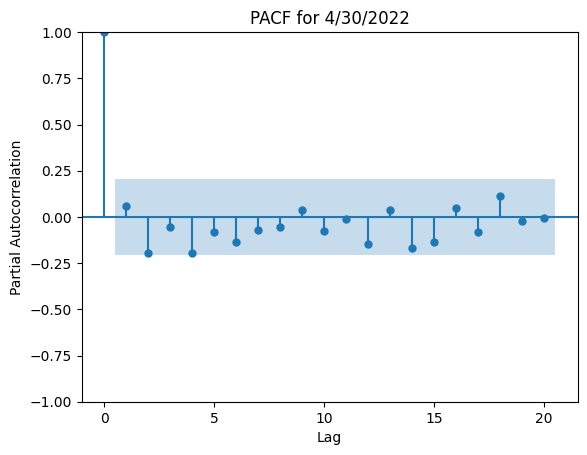

<Figure size 1000x400 with 0 Axes>

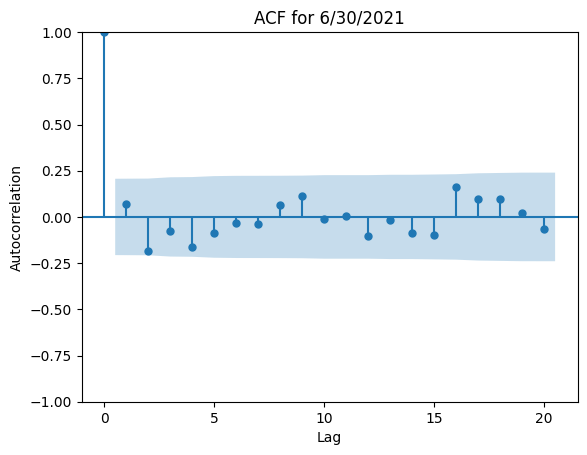

<Figure size 1000x400 with 0 Axes>

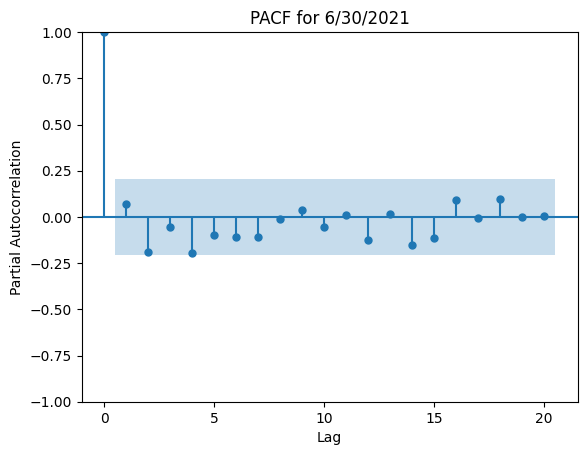

<Figure size 1000x400 with 0 Axes>

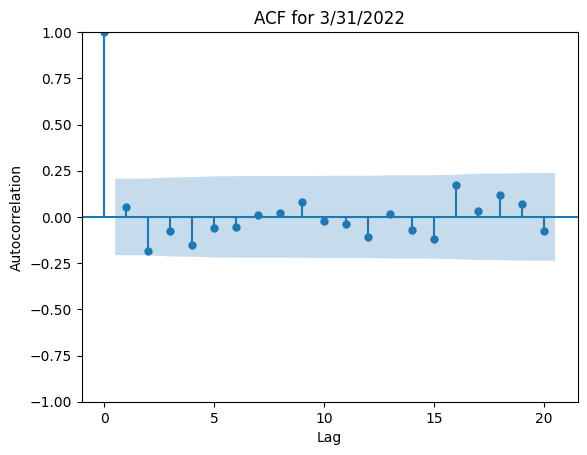

<Figure size 1000x400 with 0 Axes>

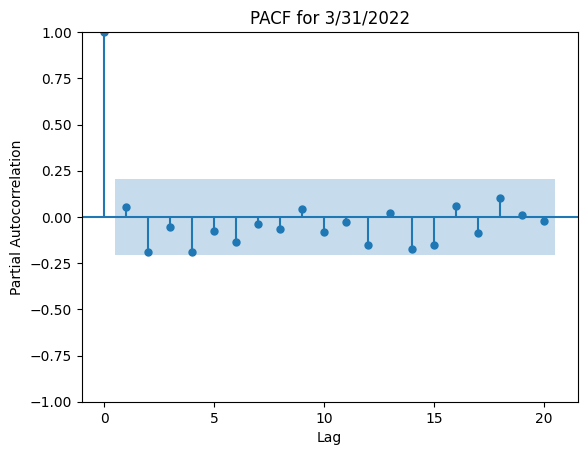

<Figure size 1000x400 with 0 Axes>

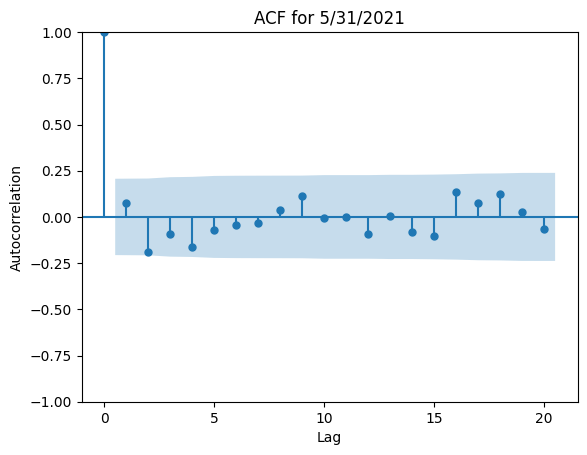

<Figure size 1000x400 with 0 Axes>

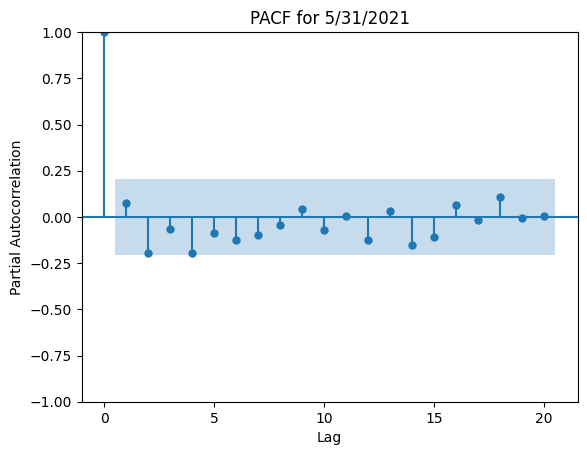

<Figure size 1000x400 with 0 Axes>

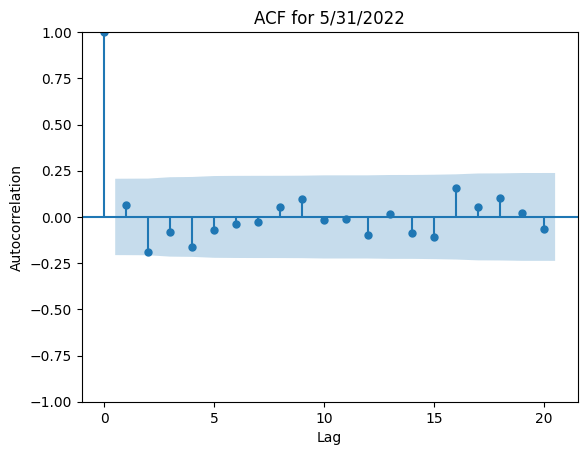

<Figure size 1000x400 with 0 Axes>

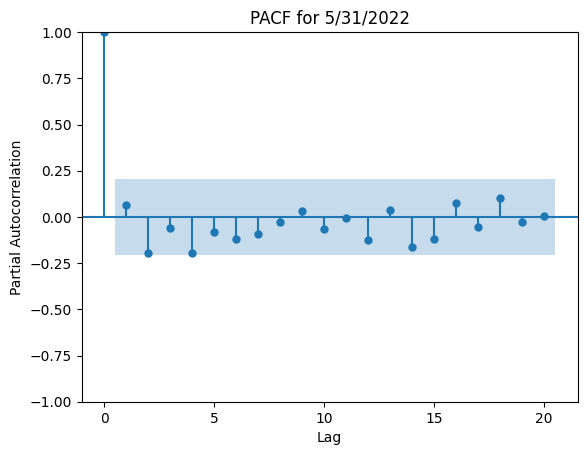

<Figure size 1000x400 with 0 Axes>

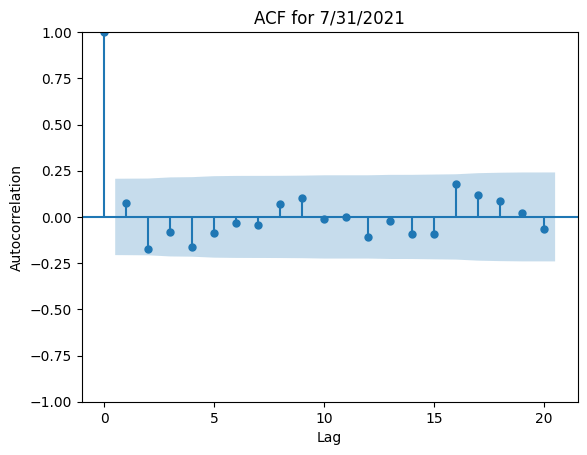

<Figure size 1000x400 with 0 Axes>

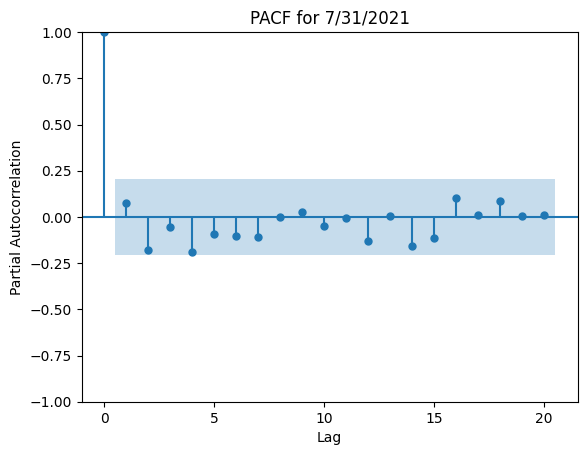

<Figure size 1000x400 with 0 Axes>

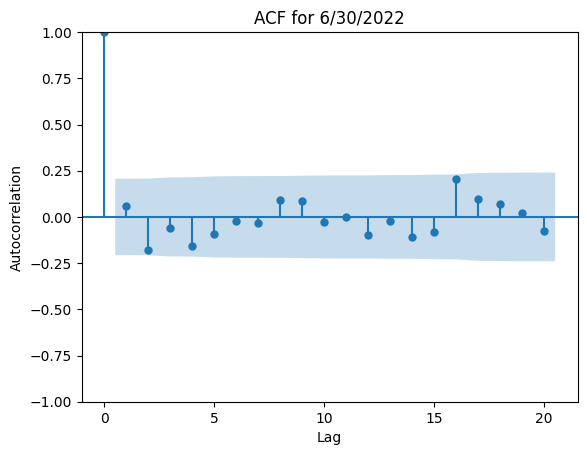

<Figure size 1000x400 with 0 Axes>

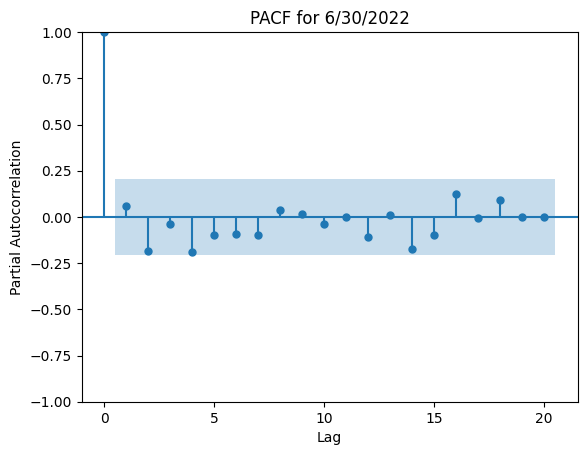

<Figure size 1000x400 with 0 Axes>

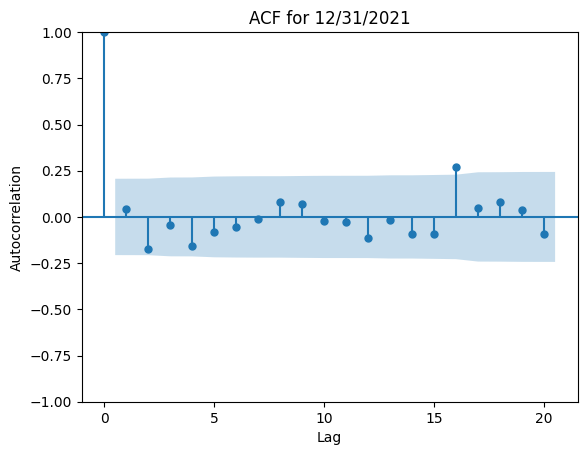

<Figure size 1000x400 with 0 Axes>

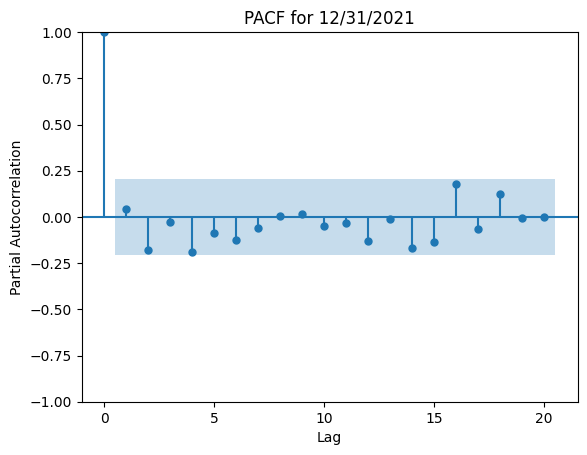

<Figure size 1000x400 with 0 Axes>

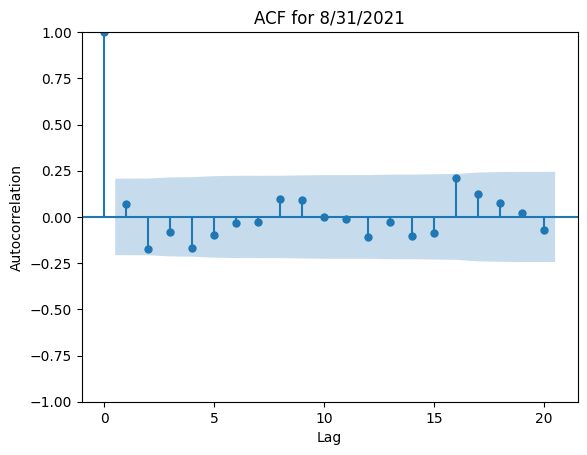

<Figure size 1000x400 with 0 Axes>

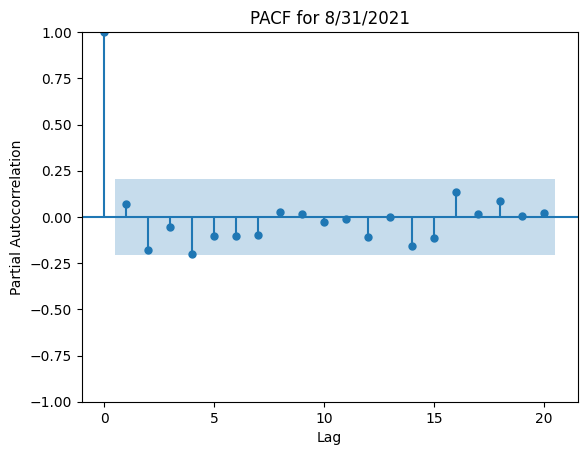

<Figure size 1000x400 with 0 Axes>

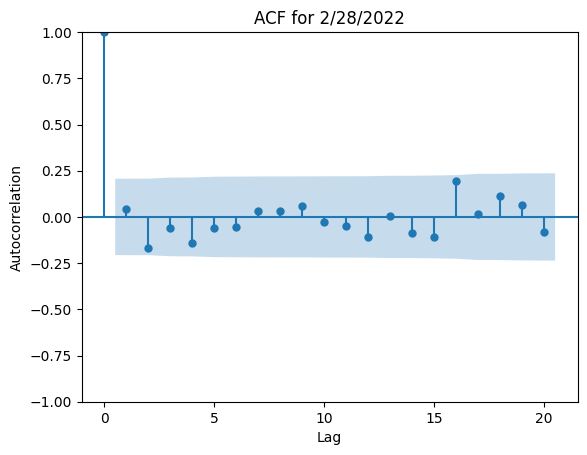

<Figure size 1000x400 with 0 Axes>

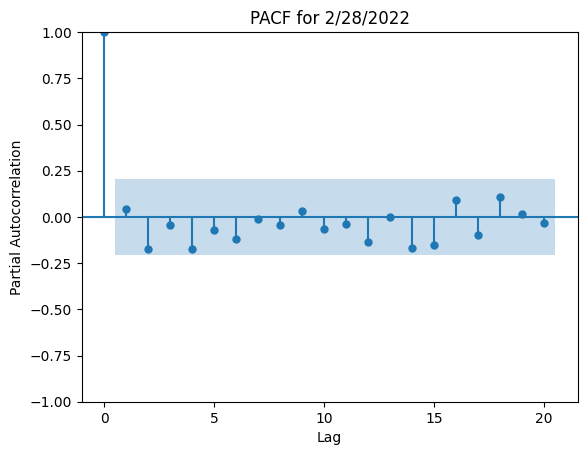

<Figure size 1000x400 with 0 Axes>

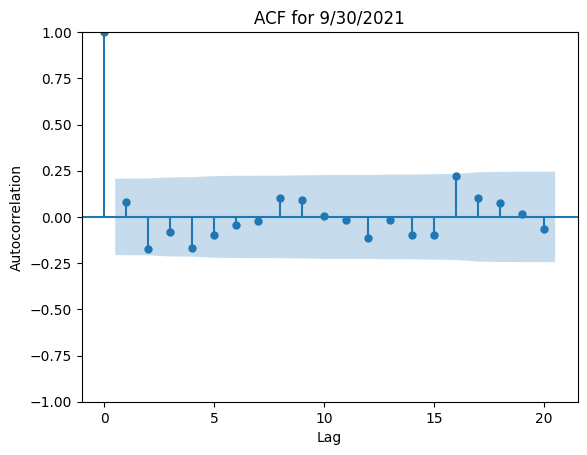

<Figure size 1000x400 with 0 Axes>

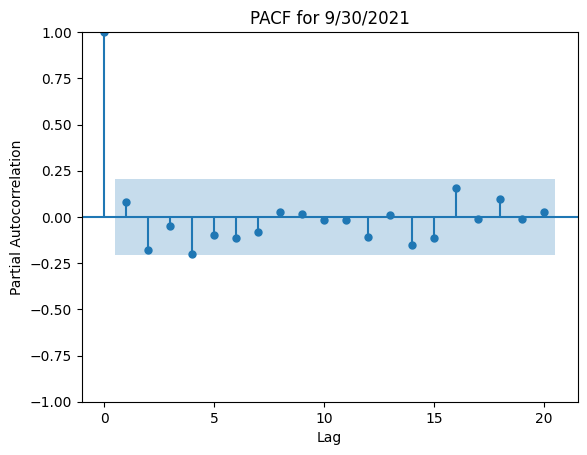

<Figure size 1000x400 with 0 Axes>

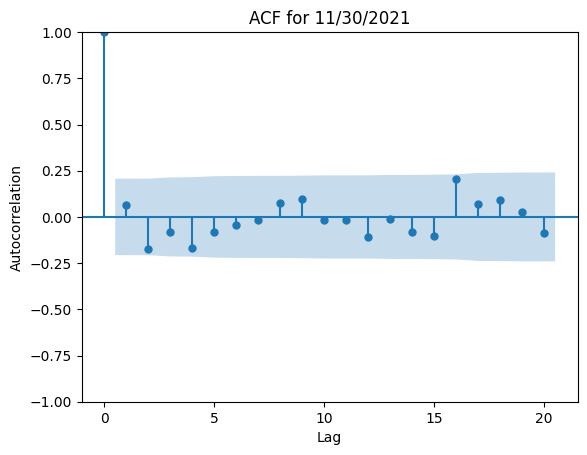

<Figure size 1000x400 with 0 Axes>

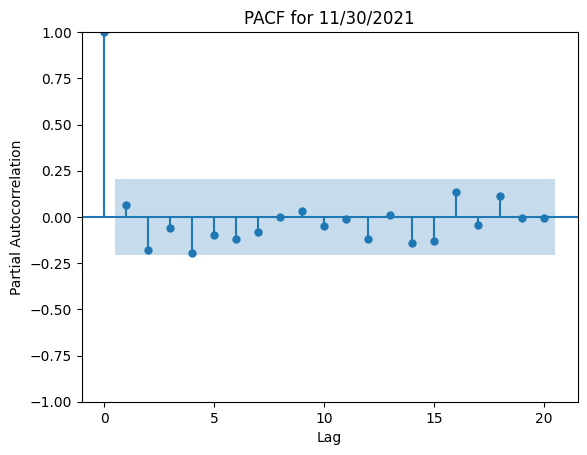

<Figure size 1000x400 with 0 Axes>

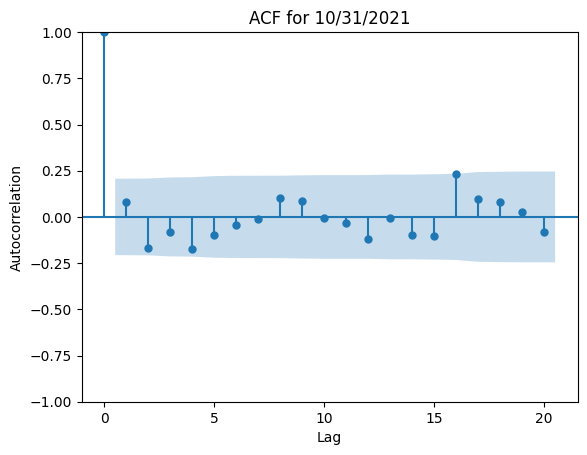

<Figure size 1000x400 with 0 Axes>

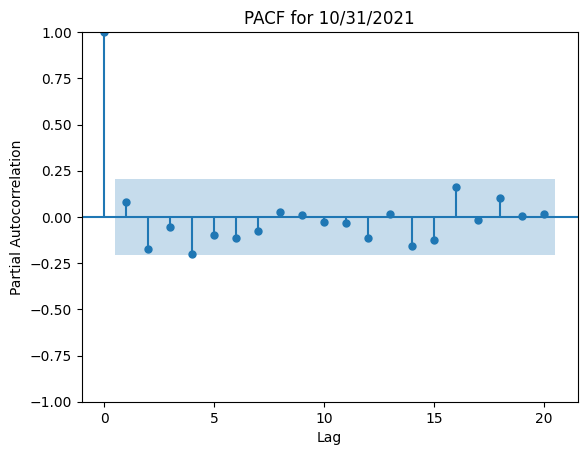

<Figure size 1000x400 with 0 Axes>

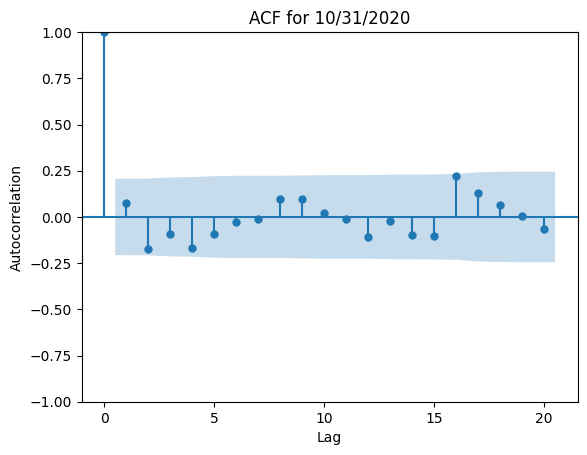

<Figure size 1000x400 with 0 Axes>

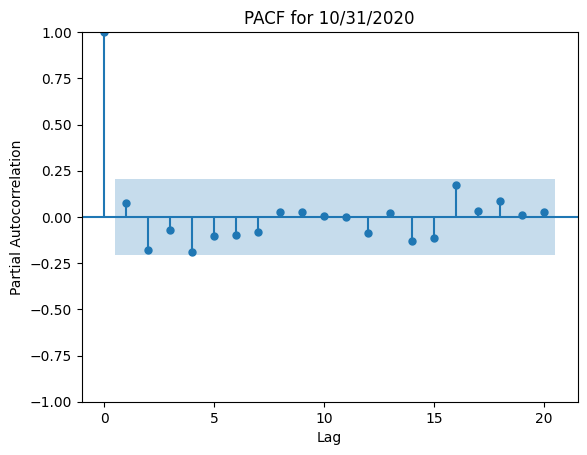

<Figure size 1000x400 with 0 Axes>

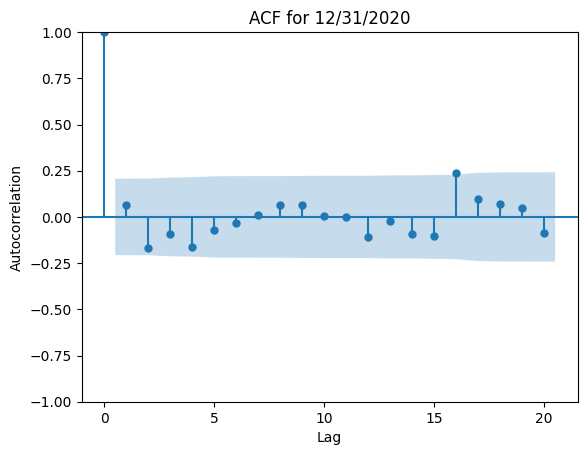

<Figure size 1000x400 with 0 Axes>

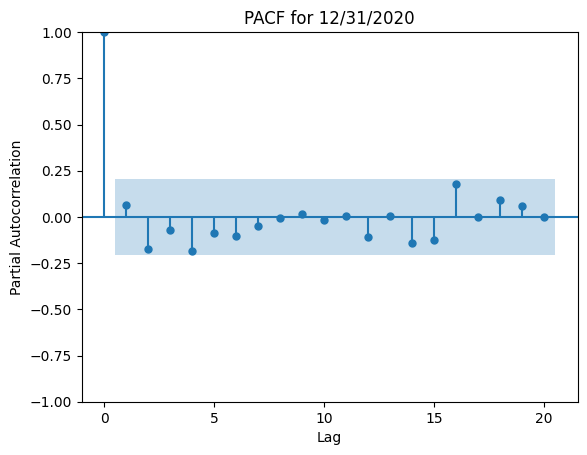

<Figure size 1000x400 with 0 Axes>

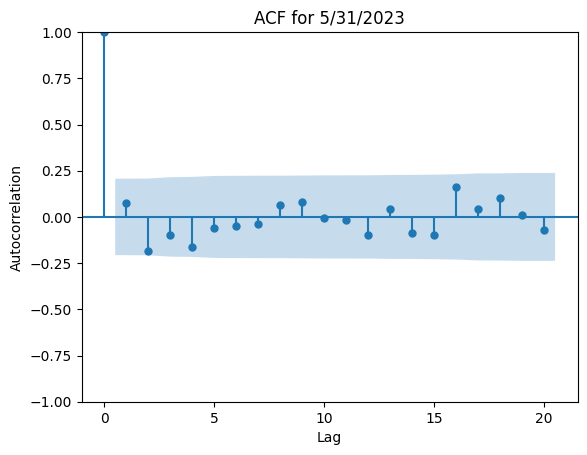

<Figure size 1000x400 with 0 Axes>

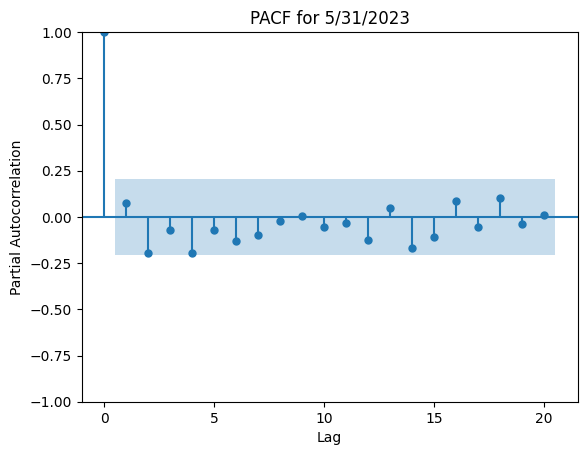

<Figure size 1000x400 with 0 Axes>

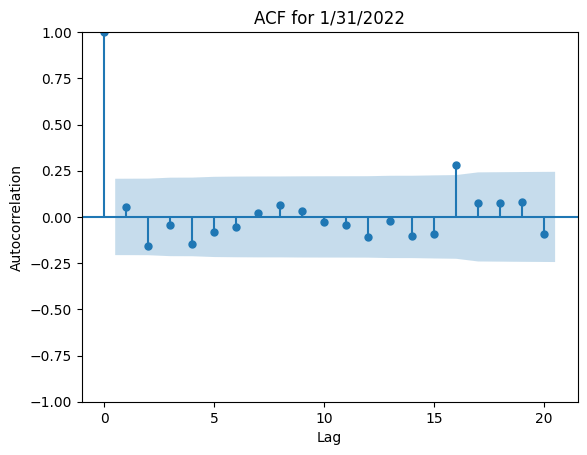

<Figure size 1000x400 with 0 Axes>

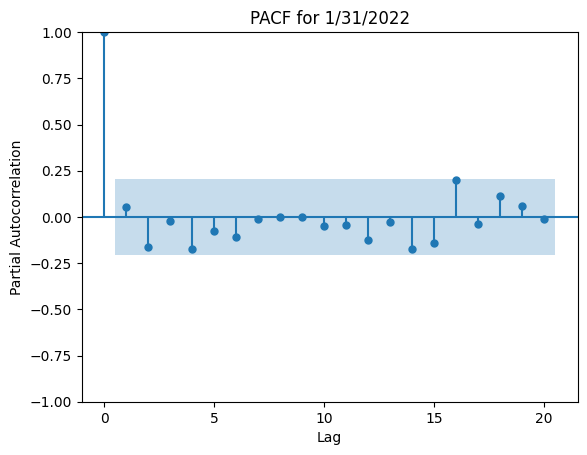

<Figure size 1000x400 with 0 Axes>

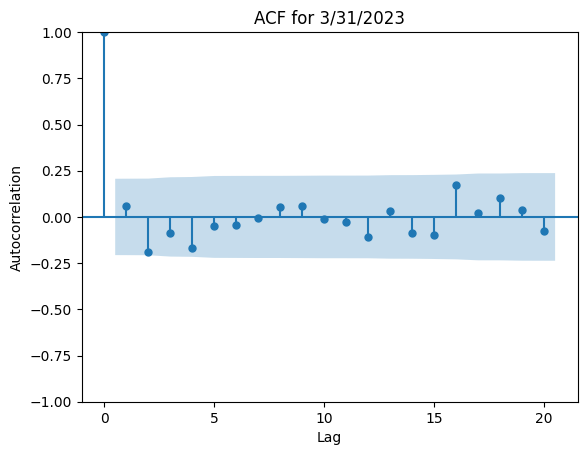

<Figure size 1000x400 with 0 Axes>

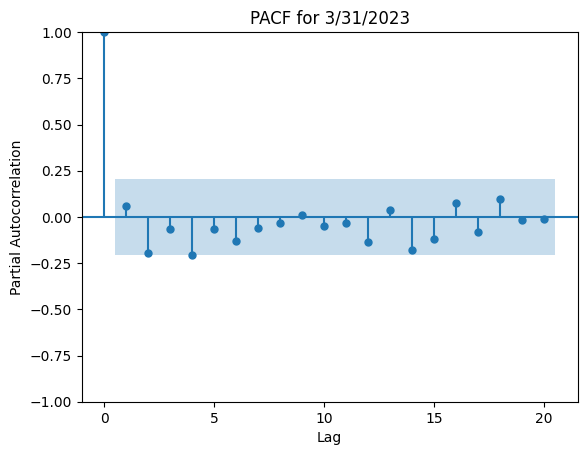

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for index, row in top_20_sales.iterrows():
    plt.figure(figsize=(10, 4))
    plot_acf(row, lags=20, title=f'ACF for {index}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

    plt.figure(figsize=(10, 4))
    plot_pacf(row, lags=20, title=f'PACF for {index}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

ARIMA Model Summary for 4/30/2021:
                               SARIMAX Results                                
Dep. Variable:              4/30/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -863.135
Date:                Tue, 23 Apr 2024   AIC                           1734.271
Time:                        01:10:27   BIC                           1744.225
Sample:                             0   HQIC                          1738.283
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1048      0.102      1.030      0.303      -0.095       0.304
ar.L2         -0.1764      0.204     -0.864      0.388      -0.577       0.224
ma.L1         -1.

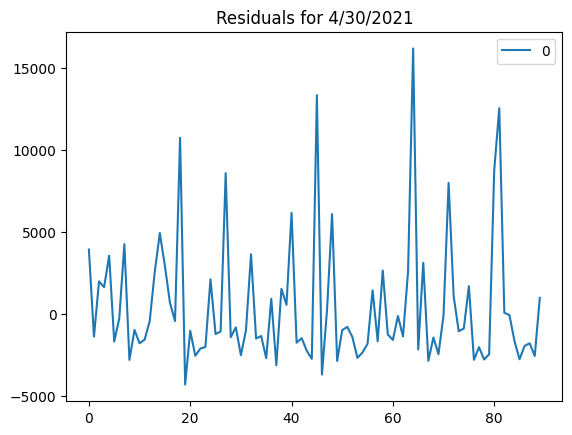

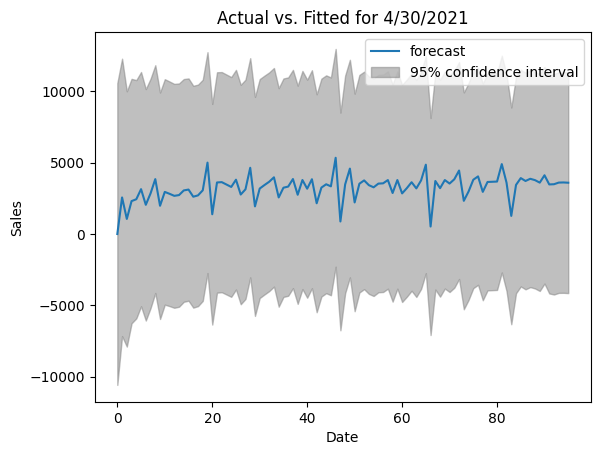

Forecast for next 5 steps for 4/30/2021:
90    4116.175579
91    3474.330847
92    3488.389716
93    3603.112971
94    3612.652832
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 3/31/2021:
                               SARIMAX Results                                
Dep. Variable:              3/31/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -860.624
Date:                Tue, 23 Apr 2024   AIC                           1729.249
Time:                        01:10:28   BIC                           1739.203
Sample:                             0   HQIC                          1733.261
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

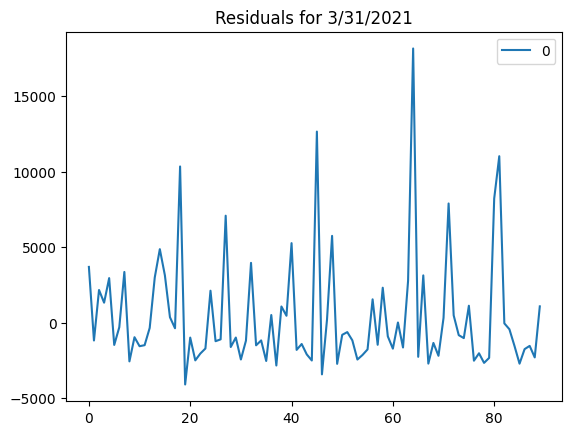

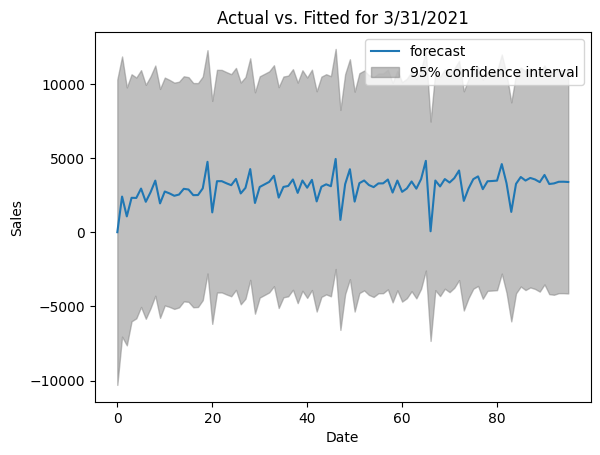

Forecast for next 5 steps for 3/31/2021:
90    3859.757325
91    3248.089042
92    3288.197810
93    3397.613866
94    3401.808140
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 4/30/2022:
                               SARIMAX Results                                
Dep. Variable:              4/30/2022   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -848.948
Date:                Tue, 23 Apr 2024   AIC                           1705.896
Time:                        01:10:30   BIC                           1715.851
Sample:                             0   HQIC                          1709.909
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

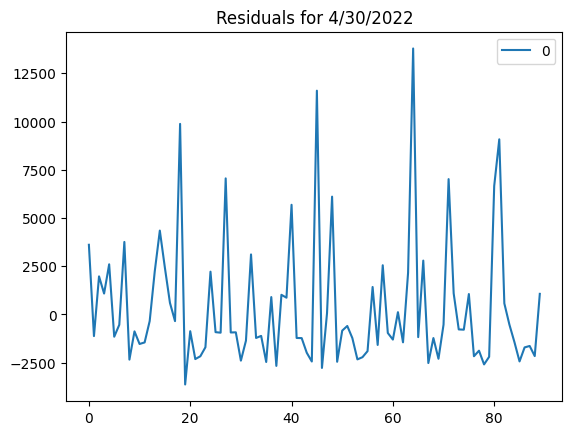

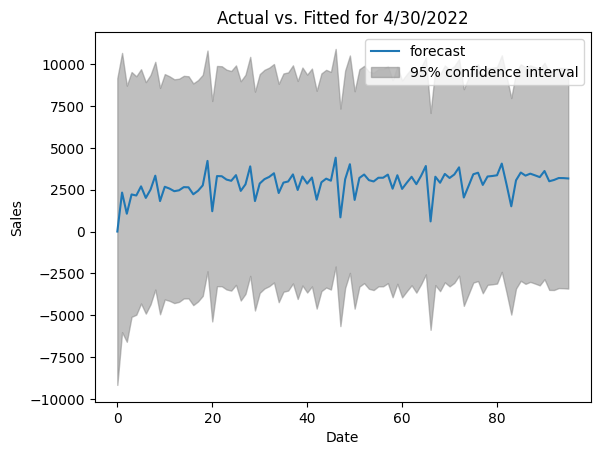

Forecast for next 5 steps for 4/30/2022:
90    3618.468054
91    3004.877417
92    3082.170490
93    3198.181074
94    3193.353166
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 6/30/2021:
                               SARIMAX Results                                
Dep. Variable:              6/30/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -876.400
Date:                Tue, 23 Apr 2024   AIC                           1760.800
Time:                        01:10:31   BIC                           1770.755
Sample:                             0   HQIC                          1764.812
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

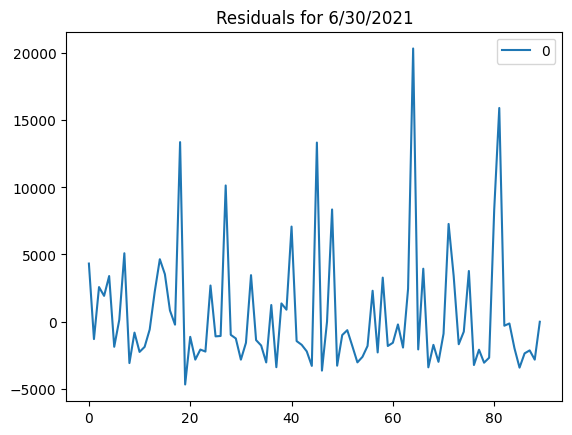

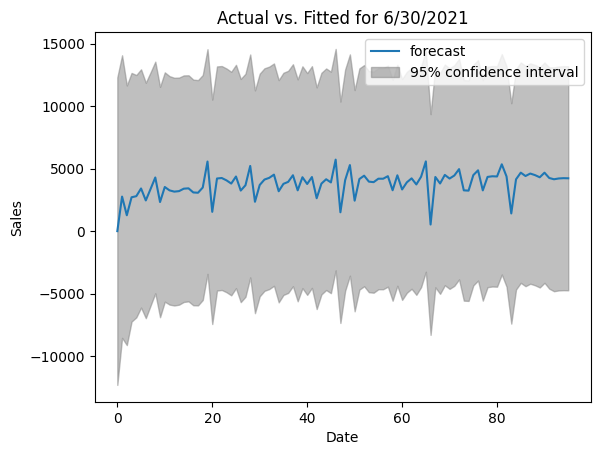

Forecast for next 5 steps for 6/30/2021:
90    4673.539904
91    4248.529351
92    4146.935410
93    4211.640648
94    4234.756789
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 3/31/2022:
                               SARIMAX Results                                
Dep. Variable:              3/31/2022   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -853.631
Date:                Tue, 23 Apr 2024   AIC                           1715.263
Time:                        01:10:33   BIC                           1725.217
Sample:                             0   HQIC                          1719.275
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

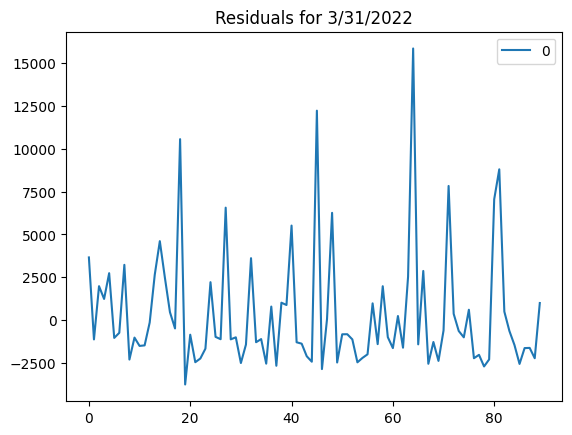

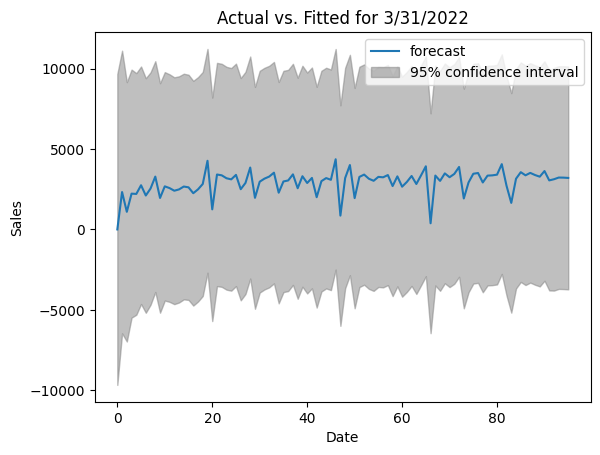

Forecast for next 5 steps for 3/31/2022:
90    3628.855349
91    3048.548700
92    3120.088253
93    3224.739330
94    3219.572468
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 5/31/2021:
                               SARIMAX Results                                
Dep. Variable:              5/31/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -860.836
Date:                Tue, 23 Apr 2024   AIC                           1729.673
Time:                        01:10:34   BIC                           1739.627
Sample:                             0   HQIC                          1733.685
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

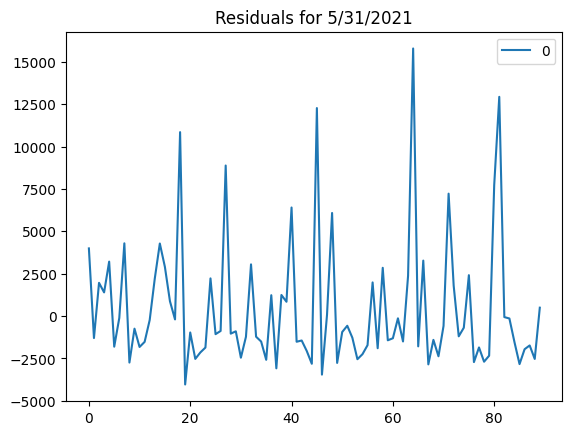

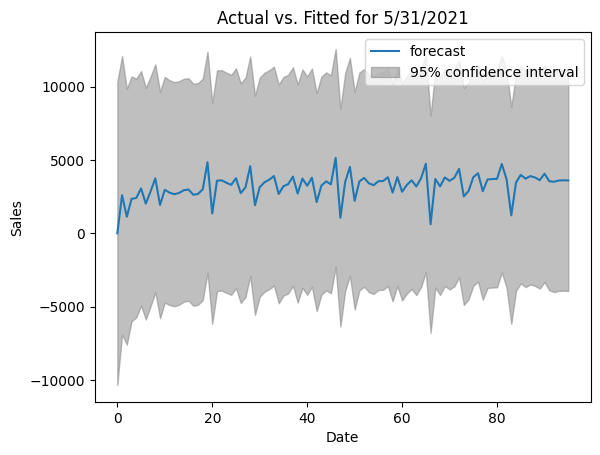

Forecast for next 5 steps for 5/31/2021:
90    4063.890397
91    3553.919279
92    3513.573239
93    3600.277575
94    3615.913241
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 5/31/2022:
                               SARIMAX Results                                
Dep. Variable:              5/31/2022   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -850.842
Date:                Tue, 23 Apr 2024   AIC                           1709.684
Time:                        01:10:36   BIC                           1719.638
Sample:                             0   HQIC                          1713.696
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

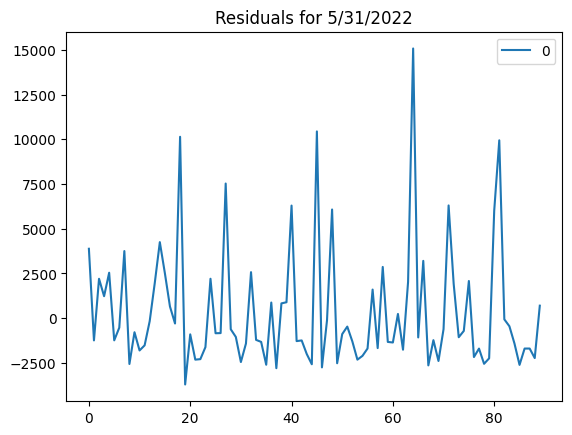

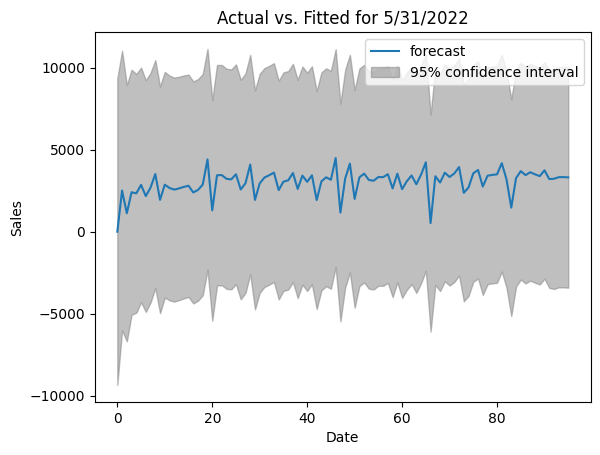

Forecast for next 5 steps for 5/31/2022:
90    3741.867555
91    3208.579666
92    3227.291477
93    3324.375088
94    3328.875104
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 7/31/2021:
                               SARIMAX Results                                
Dep. Variable:              7/31/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -870.535
Date:                Tue, 23 Apr 2024   AIC                           1749.070
Time:                        01:10:38   BIC                           1759.024
Sample:                             0   HQIC                          1753.082
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

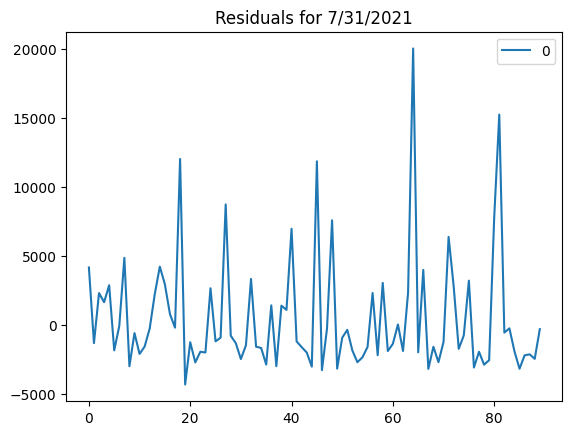

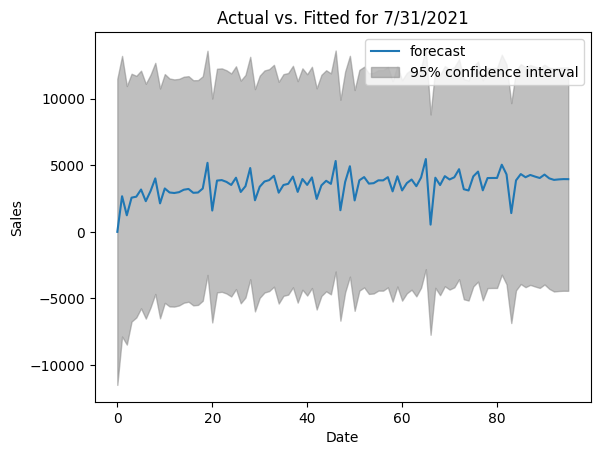

Forecast for next 5 steps for 7/31/2021:
90    4297.396274
91    4014.365872
92    3900.096506
93    3935.767867
94    3957.703988
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 6/30/2022:
                               SARIMAX Results                                
Dep. Variable:              6/30/2022   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -856.216
Date:                Tue, 23 Apr 2024   AIC                           1720.433
Time:                        01:10:39   BIC                           1730.387
Sample:                             0   HQIC                          1724.445
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

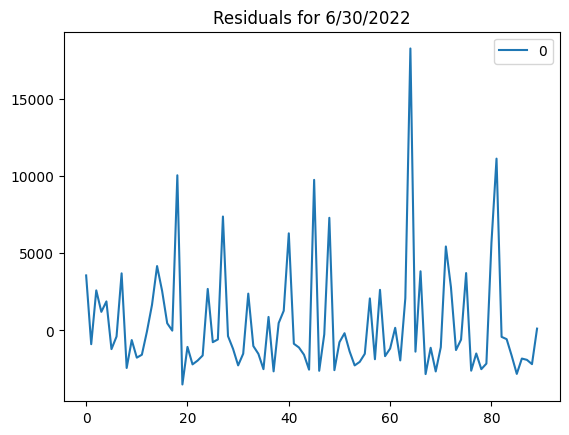

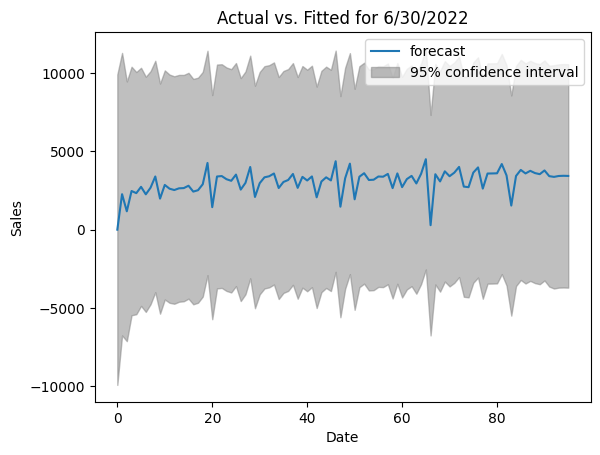

Forecast for next 5 steps for 6/30/2022:
90    3778.854409
91    3415.198202
92    3368.492952
93    3425.725637
94    3437.776395
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 12/31/2021:
                               SARIMAX Results                                
Dep. Variable:             12/31/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -855.865
Date:                Tue, 23 Apr 2024   AIC                           1719.730
Time:                        01:10:40   BIC                           1729.685
Sample:                             0   HQIC                          1723.743
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

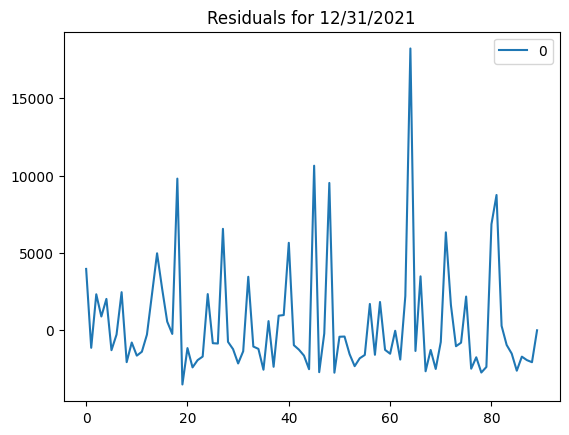

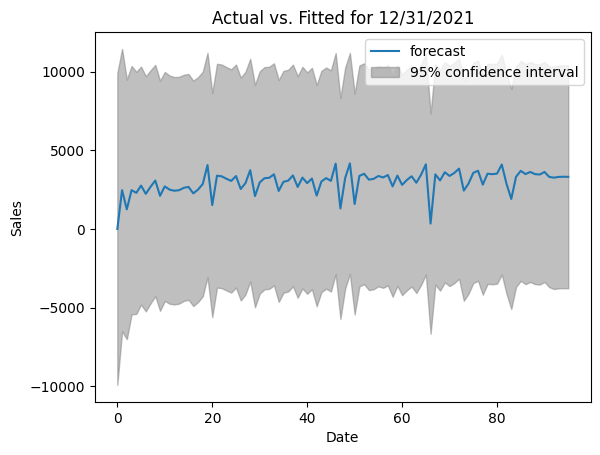

Forecast for next 5 steps for 12/31/2021:
90    3625.391705
91    3310.559557
92    3263.758725
93    3311.204184
94    3321.456787
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 8/31/2021:
                               SARIMAX Results                                
Dep. Variable:              8/31/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -869.551
Date:                Tue, 23 Apr 2024   AIC                           1747.101
Time:                        01:10:41   BIC                           1757.056
Sample:                             0   HQIC                          1751.114
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

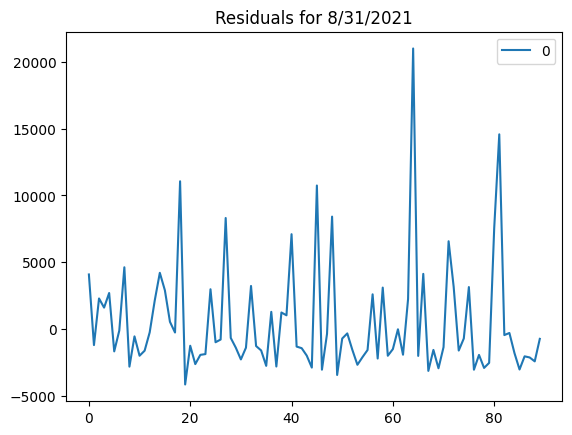

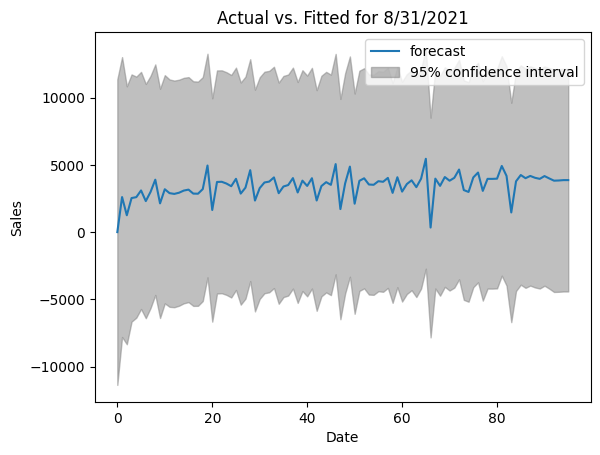

Forecast for next 5 steps for 8/31/2021:
90    4169.220225
91    3993.451548
92    3826.952775
93    3840.356354
94    3868.551329
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 2/28/2022:
                               SARIMAX Results                                
Dep. Variable:              2/28/2022   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -830.600
Date:                Tue, 23 Apr 2024   AIC                           1669.201
Time:                        01:10:42   BIC                           1679.155
Sample:                             0   HQIC                          1673.213
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

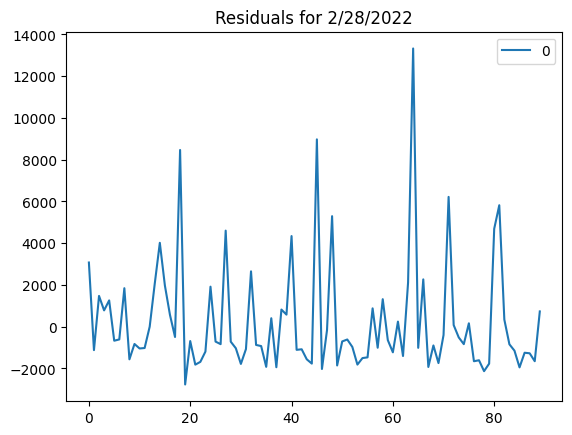

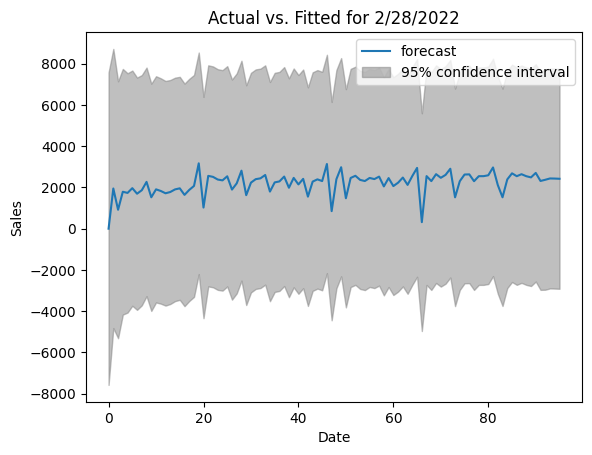

Forecast for next 5 steps for 2/28/2022:
90    2703.169294
91    2312.686312
92    2369.897177
93    2433.716133
94    2428.563244
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 9/30/2021:
                               SARIMAX Results                                
Dep. Variable:              9/30/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -860.048
Date:                Tue, 23 Apr 2024   AIC                           1728.096
Time:                        01:10:42   BIC                           1738.051
Sample:                             0   HQIC                          1732.109
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

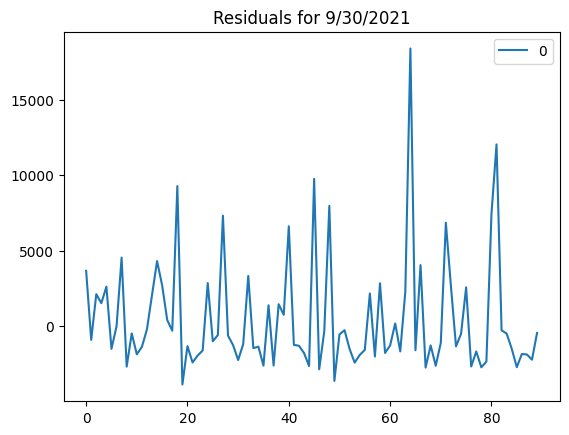

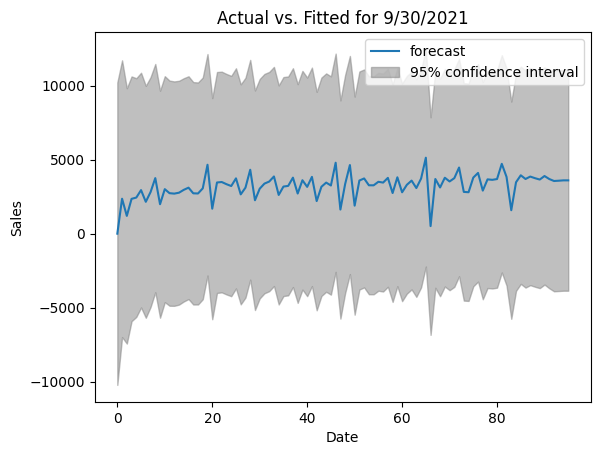

Forecast for next 5 steps for 9/30/2021:
90    3892.917268
91    3690.961955
92    3557.091543
93    3576.331373
94    3599.980039
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 11/30/2021:
                               SARIMAX Results                                
Dep. Variable:             11/30/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -852.829
Date:                Tue, 23 Apr 2024   AIC                           1713.658
Time:                        01:10:43   BIC                           1723.613
Sample:                             0   HQIC                          1717.671
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

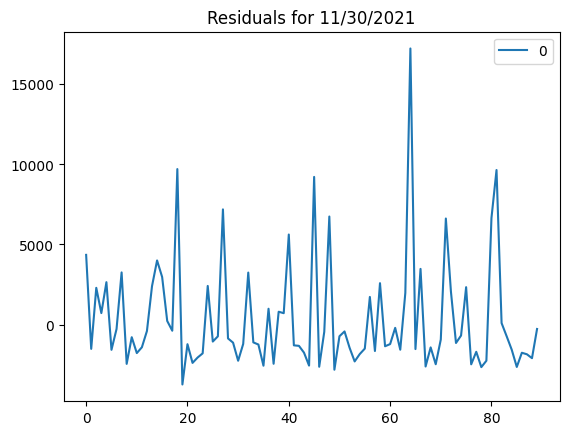

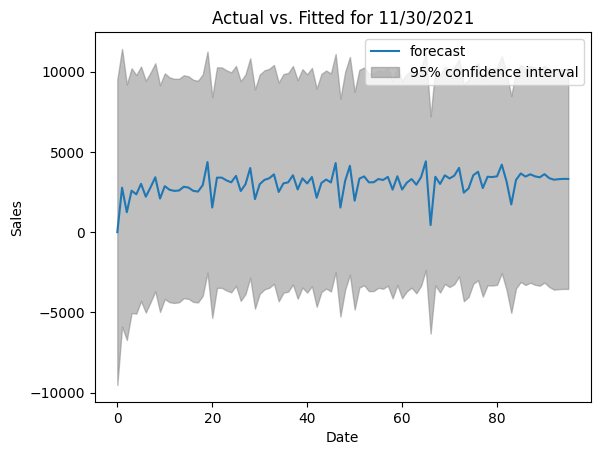

Forecast for next 5 steps for 11/30/2021:
90    3615.357995
91    3367.261564
92    3271.099008
93    3303.685479
94    3321.844120
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 10/31/2021:
                               SARIMAX Results                                
Dep. Variable:             10/31/2021   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -856.933
Date:                Tue, 23 Apr 2024   AIC                           1721.866
Time:                        01:10:44   BIC                           1731.820
Sample:                             0   HQIC                          1725.878
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

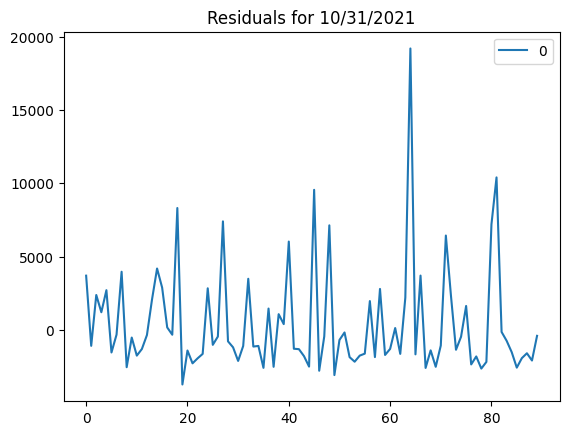

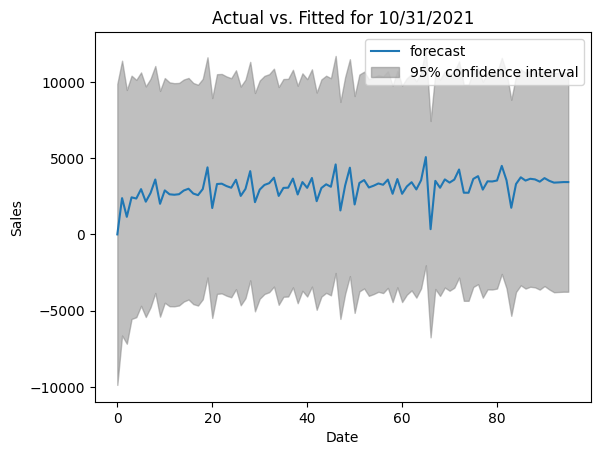

Forecast for next 5 steps for 10/31/2021:
90    3690.244954
91    3512.176657
92    3393.305072
93    3409.506420
94    3429.839100
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 10/31/2020:
                               SARIMAX Results                                
Dep. Variable:             10/31/2020   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -861.788
Date:                Tue, 23 Apr 2024   AIC                           1731.576
Time:                        01:10:44   BIC                           1741.531
Sample:                             0   HQIC                          1735.588
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

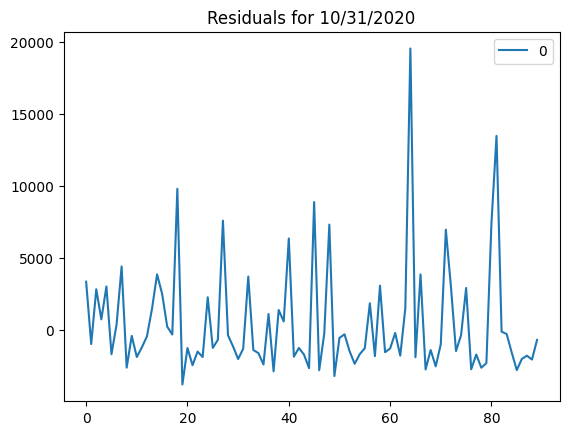

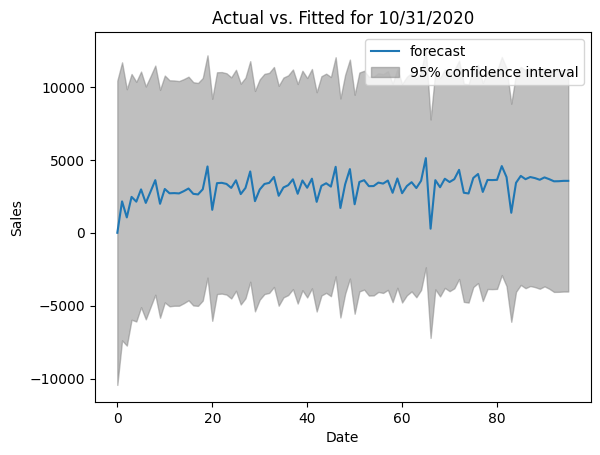

Forecast for next 5 steps for 10/31/2020:
90    3798.956728
91    3675.913360
92    3530.863385
93    3537.184430
94    3561.071088
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 12/31/2020:
                               SARIMAX Results                                
Dep. Variable:             12/31/2020   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -858.642
Date:                Tue, 23 Apr 2024   AIC                           1725.285
Time:                        01:10:45   BIC                           1735.239
Sample:                             0   HQIC                          1729.297
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L

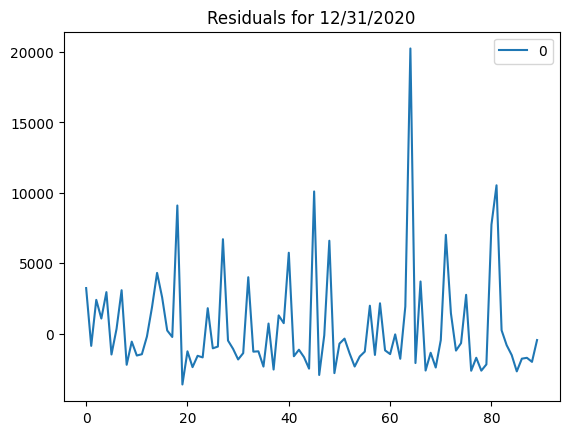

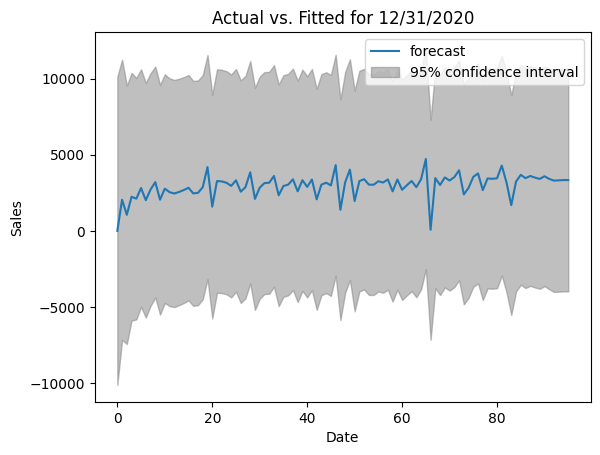

Forecast for next 5 steps for 12/31/2020:
90    3586.418425
91    3411.886348
92    3300.063210
93    3317.930034
94    3336.647125
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 5/31/2023:
                               SARIMAX Results                                
Dep. Variable:              5/31/2023   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -821.462
Date:                Tue, 23 Apr 2024   AIC                           1650.925
Time:                        01:10:46   BIC                           1660.879
Sample:                             0   HQIC                          1654.937
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1

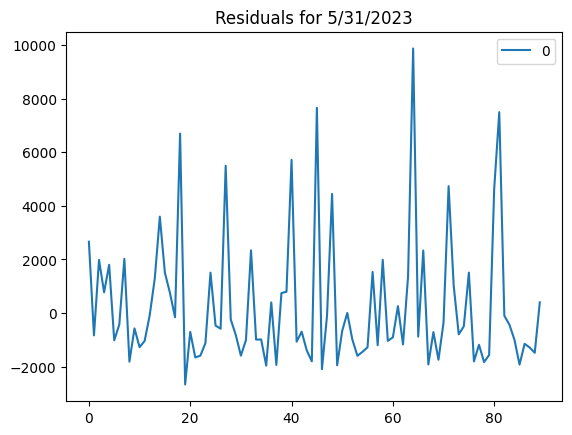

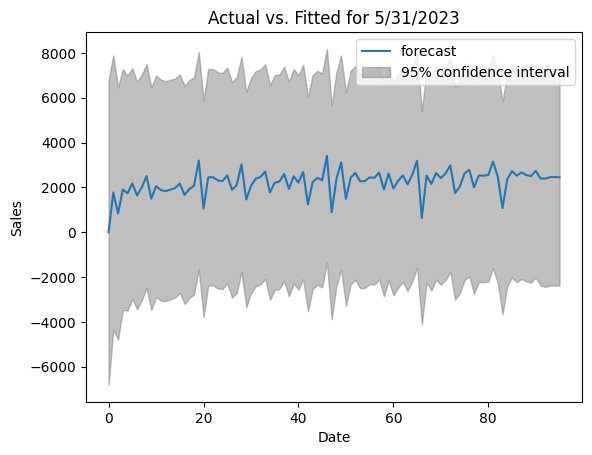

Forecast for next 5 steps for 5/31/2023:
90    2736.428602
91    2397.332839
92    2393.792615
93    2453.233841
94    2459.502211
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 1/31/2022:
                               SARIMAX Results                                
Dep. Variable:              1/31/2022   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -837.367
Date:                Tue, 23 Apr 2024   AIC                           1682.733
Time:                        01:10:47   BIC                           1692.688
Sample:                             0   HQIC                          1686.746
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

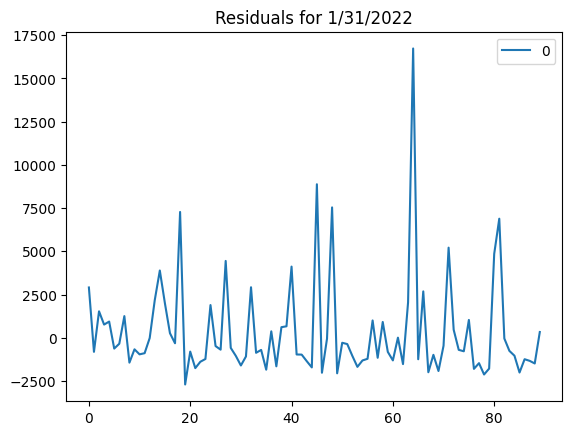

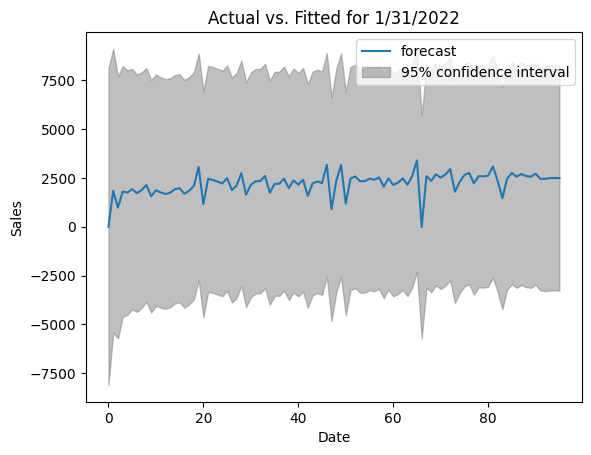

Forecast for next 5 steps for 1/31/2022:
90    2716.321665
91    2442.263671
92    2448.761186
93    2489.607537
94    2491.409805
Name: predicted_mean, dtype: float64

ARIMA Model Summary for 3/31/2023:
                               SARIMAX Results                                
Dep. Variable:              3/31/2023   No. Observations:                   90
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -814.171
Date:                Tue, 23 Apr 2024   AIC                           1636.341
Time:                        01:10:48   BIC                           1646.296
Sample:                             0   HQIC                          1640.354
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

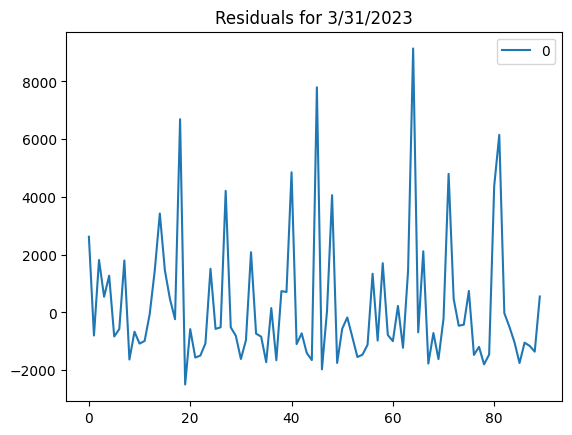

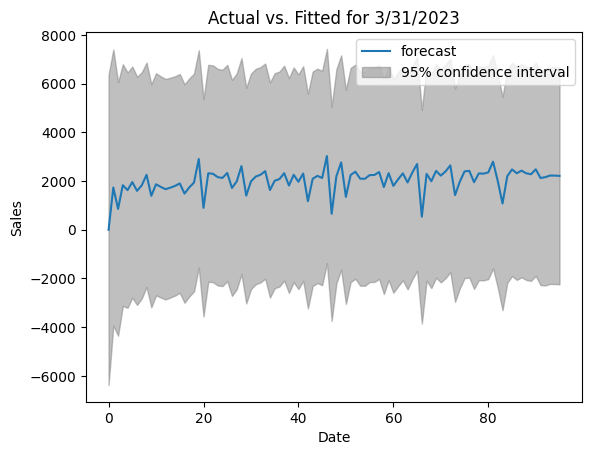

Forecast for next 5 steps for 3/31/2023:
90    2480.674190
91    2123.258100
92    2157.737001
93    2223.517106
94    2222.407799
Name: predicted_mean, dtype: float64



In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Fit ARIMA models to the top 20 time series data
for index, row in top_20_sales.iterrows():
    # Define the parameters for ARIMA model (p, d, q)
    p = 2  # AutoRegressive (AR) order
    d = 1  # Integrated (I) order (to make time series stationary)
    q = 1  # Moving Average (MA) order

    # Fit ARIMA model
    model = ARIMA(row, order=(p, d, q))
    model_fit = model.fit()

    # Print model summary
    print(f"ARIMA Model Summary for {index}:")
    print(model_fit.summary())

    # Plot residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(title=f'Residuals for {index}')
    plt.show()

    # Plot Actual vs. Fitted
    plot_predict(model_fit, start=0, end=len(row)+5)
    plt.title(f'Actual vs. Fitted for {index}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

    # Forecast for next 5 steps
    forecast_steps = 5
    forecast = model_fit.forecast(steps=forecast_steps)
    print(f"Forecast for next {forecast_steps} steps for {index}:")
    print(forecast)
    print()


In [ ]:
# Logistic Regression

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline


feature_cols = ['1/31/2023', '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023',
                '6/30/2023', '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023',
                '11/30/2023', '12/31/2023', '1/31/2024']



# Define VectorAssembler to assemble features
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol="features")

# Define Logistic Regression model
lr = LogisticRegression(labelCol="2/29/2024", featuresCol="features")

# Define pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and testing sets
(training_data, test_data) = Sales.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show the predictions
predictions.select("features", "2/29/2024", "prediction").show()



+--------------------+---------+----------+
|            features|2/29/2024|prediction|
+--------------------+---------+----------+
|[550.0,633.0,782....|      599|     508.0|
|[532.0,565.0,785....|      545|     544.0|
|[490.0,585.0,799....|      530|     547.0|
|[705.0,559.0,626....|      535|     502.0|
|[681.0,759.0,1051...|      809|     878.0|
|[747.0,1004.0,139...|      752|    1136.0|
|[427.0,518.0,624....|      541|     443.0|
|[1519.0,1798.0,26...|     1754|    1877.0|
|[5761.0,6574.0,99...|     5881|    6073.0|
|[845.0,937.0,1209...|     1003|    1183.0|
|[2147.0,2302.0,31...|     2253|    2360.0|
|[578.0,495.0,706....|      410|     424.0|
|[11431.0,10102.0,...|     8225|    4058.0|
|[2076.0,2547.0,33...|     2225|    2336.0|
|[347.0,464.0,577....|      349|     380.0|
|[1400.0,1661.0,22...|     1464|    1877.0|
|[370.0,320.0,371....|      354|     328.0|
+--------------------+---------+----------+



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator


evaluator = RegressionEvaluator(labelCol='2/29/2024', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

evaluator = RegressionEvaluator(labelCol='2/29/2024', predictionCol='prediction', metricName='mae')
mae = evaluator.evaluate(predictions)

print("Root Mean Square Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)



Root Mean Square Error (RMSE): 1023.7168438931676
Mean Absolute Error (MAE): 356.29411764705884


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator


evaluator = RegressionEvaluator(labelCol='2/29/2024', predictionCol='prediction', metricName='r2')
r_squared = evaluator.evaluate(predictions)

print("R-squared (coefficient of determination):", r_squared)


R-squared (coefficient of determination): 0.7617075192020867


In [ ]:
#TCN

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Define feature columns
feature_cols = ['1/31/2023', '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023',
                '6/30/2023', '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023',
                '11/30/2023', '12/31/2023', '1/31/2024']

# Define target column
target = '2/29/2024'

# Define VectorAssembler to assemble features
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol="features")

# Define RandomForestRegressor model
rf = RandomForestRegressor(labelCol=target, featuresCol="features")

# Define pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and testing sets
(training_data, test_data) = Sales.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show the predictions
predictions.select("features", target, "prediction").show()

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+--------------------+---------+------------------+
|            features|2/29/2024|        prediction|
+--------------------+---------+------------------+
|[550.0,633.0,782....|      599| 513.9357276546983|
|[532.0,565.0,785....|      545|486.25487012987014|
|[490.0,585.0,799....|      530| 507.0844289533996|
|[705.0,559.0,626....|      535| 501.0584982174688|
|[681.0,759.0,1051...|      809| 713.6341425241425|
|[747.0,1004.0,139...|      752|  851.906187978688|
|[427.0,518.0,624....|      541| 442.0872474747475|
|[1519.0,1798.0,26...|     1754|1604.7606547619048|
|[5761.0,6574.0,99...|     5881|           5570.95|
|[845.0,937.0,1209...|     1003|1070.1374242424242|
|[2147.0,2302.0,31...|     2253| 2219.620238095238|
|[578.0,495.0,706....|      410| 482.8186028350735|
|[11431.0,10102.0,...|     8225|           5570.95|
|[2076.0,2547.0,33...|     2225|2225.0533333333333|
|[347.0,464.0,577....|      349|383.65724747474746|
|[1400.0,1661.0,22...|     1464|1463.2657142857147|
|[370.0,320.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define feature columns
feature_cols = ['1/31/2023', '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023',
                '6/30/2023', '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023',
                '11/30/2023', '12/31/2023', '1/31/2024']

# Define target column
target = '2/29/2024'

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split the data into training and testing sets
(training_data, test_data) = Sales.randomSplit([0.8, 0.2], seed=42)

# Define CNN architecture using Keras
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(feature_cols), 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
X_train = training_data.select(feature_cols).toPandas().values.reshape(-1, len(feature_cols), 1)
y_train = training_data.select(target).toPandas().values
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
X_test = test_data.select(feature_cols).toPandas().values.reshape(-1, len(feature_cols), 1)
y_test = test_data.select(target).toPandas().values
loss = model.evaluate(X_test, y_test, verbose=0)
print("Mean Squared Error on Test Data:", loss)


Epoch 1/10
3/3 [==============================] - 1s 12ms/step - loss: 4682518.5000
Epoch 2/10
3/3 [==============================] - 0s 8ms/step - loss: 1598420.1250
Epoch 3/10
3/3 [==============================] - 0s 6ms/step - loss: 358497.8750
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 83249.6328
Epoch 5/10
3/3 [==============================] - 0s 6ms/step - loss: 366276.0000
Epoch 6/10
3/3 [==============================] - 0s 6ms/step - loss: 526144.3125
Epoch 7/10
3/3 [==============================] - 0s 6ms/step - loss: 418269.5938
Epoch 8/10
3/3 [==============================] - 0s 5ms/step - loss: 227996.1562
Epoch 9/10
3/3 [==============================] - 0s 6ms/step - loss: 106388.1172
Epoch 10/10
3/3 [==============================] - 0s 6ms/step - loss: 88356.7500
Mean Squared Error on Test Data: 42577.10546875


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define feature columns
feature_cols = ['1/31/2023', '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023',
                '6/30/2023', '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023',
                '11/30/2023', '12/31/2023', '1/31/2024']

# Define target column
target = '2/29/2024'

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split the data into training and testing sets
(training_data, test_data) = Sales.randomSplit([0.8, 0.2], seed=42)

# Define CNN architecture using Keras
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(feature_cols), 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
X_train = training_data.select(feature_cols).toPandas().values.reshape(-1, len(feature_cols), 1)
y_train = training_data.select(target).toPandas().values
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on training data
X_test_train = training_data.select(feature_cols).toPandas().values.reshape(-1, len(feature_cols), 1)
y_test_train = training_data.select(target).toPandas().values
loss_train = model.evaluate(X_test_train, y_test_train, verbose=0)

# Evaluate the model on test data
X_test = test_data.select(feature_cols).toPandas().values.reshape(-1, len(feature_cols), 1)
y_test = test_data.select(target).toPandas().values
loss_test = model.evaluate(X_test, y_test, verbose=0)

# Calculate accuracy
accuracy_train = 1 - loss_train / np.var(y_test_train)
accuracy_test = 1 - loss_test / np.var(y_test)

# Convert accuracy to percentage
accuracy_percentage_train = accuracy_train * 100
accuracy_percentage_test = accuracy_test * 100

print("Mean Squared Error on Training Data:", loss_train)
print("Mean Squared Error on Test Data:", loss_test)
print("Accuracy on Training Data: {:.2f}%".format(accuracy_percentage_train))
print("Accuracy on Test Data: {:.2f}%".format(accuracy_percentage_test))


Epoch 1/10
3/3 [==============================] - 1s 5ms/step - loss: 3101488.2500
Epoch 2/10
3/3 [==============================] - 0s 5ms/step - loss: 1477123.2500
Epoch 3/10
3/3 [==============================] - 0s 5ms/step - loss: 440839.4062
Epoch 4/10
3/3 [==============================] - 0s 5ms/step - loss: 120479.1797
Epoch 5/10
3/3 [==============================] - 0s 5ms/step - loss: 148111.0938
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 241537.3750
Epoch 7/10
3/3 [==============================] - 0s 5ms/step - loss: 253804.6094
Epoch 8/10
3/3 [==============================] - 0s 5ms/step - loss: 176837.5000
Epoch 9/10
3/3 [==============================] - 0s 5ms/step - loss: 113326.3125
Epoch 10/10
3/3 [==============================] - 0s 4ms/step - loss: 85051.4141
Mean Squared Error on Training Data: 93854.9140625
Mean Squared Error on Test Data: 39882.01953125
Accuracy on Training Data: 94.76%
Accuracy on Test Data: 99.09%


In [ ]:
#K-means clustering

In [ ]:
#XGboost

In [ ]:
print(Sales.head())

# Check if the column names specified in feature_cols and target match the actual column names in your DataFrame
print("Columns in DataFrame:", Sales.columns)

Row(RegionID=394913, SizeRank=1, RegionName='New York, NY', RegionType='msa', StateName='NY', 3/31/2018=14837, 4/30/2018=15684, 5/31/2018=17709, 6/30/2018=20490, 7/31/2018=20516, 8/31/2018=22117, 9/30/2018=16512, 10/31/2018=18707, 11/30/2018=16457, 12/31/2018=15954, 1/31/2019=14387, 2/28/2019=11979, 3/31/2019=14233, 4/30/2019=15088, 5/31/2019=17452, 6/30/2019=18507, 7/31/2019=20206, 8/31/2019=20336, 9/30/2019=17236, 10/31/2019=17825, 11/30/2019=15285, 12/31/2019=16846, 1/31/2020=15517, 2/29/2020=13080, 3/31/2020=13594, 4/30/2020=10713, 5/31/2020=11211, 6/30/2020=13732, 7/31/2020=16933, 8/31/2020=19262, 9/30/2020=20394, 10/31/2020=23100, 11/30/2020=20352, 12/31/2020=23649, 1/31/2021=20335, 2/28/2021=17395, 3/31/2021=21749, 4/30/2021=19941, 5/31/2021=19549, 6/30/2021=24690, 7/31/2021=24126, 8/31/2021=24964, 9/30/2021=22121, 10/31/2021=22753, 11/30/2021=20662, 12/31/2021=21669, 1/31/2022=19327, 2/28/2022=15883, 3/31/2022=19216, 4/30/2022=17118, 5/31/2022=18558, 6/30/2022=21823, 7/31/2022=

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Gradient Boosted Trees Example") \
    .getOrCreate()



# Define feature columns
feature_cols = ['1/31/2023', '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023',
                '6/30/2023', '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023',
                '11/30/2023', '12/31/2023', '1/31/2024']

# Define target column
target = '2/29/2024'

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(Sales)

# Split data into train and test sets
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

# Initialize GBTRegressor
gbt_regressor = GBTRegressor(featuresCol="features", labelCol=target)

# Train the model
gbt_model = gbt_regressor.fit(train_data)

# Make predictions
predictions = gbt_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 651.948135414944


In [ ]:
#

In [ ]:
#Sales Prediction

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Create a Spark session

sales_features = ['1/31/2023', '2/28/2023', '3/31/2023', '4/30/2023', '5/31/2023',
                '6/30/2023', '7/31/2023', '8/31/2023', '9/30/2023', '10/31/2023',
                '11/30/2023', '12/31/2023', '1/31/2024']
target_variable = '2/29/2024'
# Assemble the features vector
sales_assembler = VectorAssembler(inputCols=sales_features, outputCol="features", handleInvalid="skip")


# Step 2: Create Linear Regression Model
lr_sales = LinearRegression(labelCol=target_variable)

# Step 3: Create a pipeline for the DataFrame
sales_pipeline = Pipeline(stages=[sales_assembler, lr_sales])


# Step 4: Fit the pipeline on the DataFrame
sales_model = sales_pipeline.fit(Sales)

# Step 5: Predict using the trained model
sales_predictions = sales_model.transform(Sales)


from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol=target_variable, metricName="rmse")
rmse = evaluator.evaluate(sales_predictions)
print("Root Mean Squared Error (RMSE):", rmse)

evaluator_mae = RegressionEvaluator(labelCol=target_variable, metricName="mae")
mae = evaluator_mae.evaluate(sales_predictions)

evaluator_r2 = RegressionEvaluator(labelCol=target_variable, metricName="r2")
r2 = evaluator_r2.evaluate(sales_predictions)



# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# Print the predictions or further analyze the results as per your requirements
sales_predictions.show()

Root Mean Squared Error (RMSE): 130.78698037526195
Root Mean Squared Error (RMSE): 130.78698037526195
Mean Absolute Error (MAE): 86.65299421362208
R-squared (R2): 0.9925228342806846
+--------+--------+------------------+----------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+---------+--------------------+

In [ ]:
# KNN Nearest Neighbour

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load Sales DataFrame and clean data
df_cleaned = Sales.na.drop()

# Assemble features with handleInvalid="skip"
feature_columns = df_cleaned.columns[5:]  # Selecting numeric columns as features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_assembled = assembler.transform(df_cleaned)

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df_assembled.select("SizeRank", "features").toPandas()

# Initialize and train KNN regressor from scikit-learn
knn_regressor = KNeighborsRegressor(n_neighbors=3)  # Adjust k as needed
knn_regressor.fit(pandas_df["features"].tolist(), pandas_df["SizeRank"].tolist())

# Make predictions
predictions = knn_regressor.predict(pandas_df["features"].tolist())

# Calculate residuals
residuals = pandas_df["SizeRank"] - predictions

# Compute evaluation metrics
mae = mean_absolute_error(pandas_df["SizeRank"], predictions)
rmse = mean_squared_error(pandas_df["SizeRank"], predictions, squared=False)
r2 = r2_score(pandas_df["SizeRank"], predictions)

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Convert Pandas DataFrame back to Spark DataFrame for further analysis or storage if needed
spark_df_predictions = spark.createDataFrame(pandas_df)

# Show available column names in spark_df_predictions
spark_df_predictions.printSchema()

# Assuming "RegionName" is not available, you can select the appropriate columns for display
spark_df_predictions.select("SizeRank", "features",).show()

Mean Absolute Error (MAE): 6.562962962962964
Root Mean Squared Error (RMSE): 10.038936542960128
R-squared (R2): 0.8810451565595657
root
 |-- SizeRank: long (nullable = true)
 |-- features: vector (nullable = true)

+--------+--------------------+
|SizeRank|            features|
+--------+--------------------+
|      40|[2724.0,2977.0,32...|
|      89|[943.0,1023.0,111...|
|      27|[2661.0,3077.0,33...|
|      38|[2296.0,2379.0,28...|
|      12|[4071.0,4241.0,49...|
|      82|[1134.0,1228.0,13...|
|      39|[1419.0,1567.0,19...|
|      15|[5275.0,5893.0,68...|
|      57|[911.0,946.0,1068...|
|      52|[1030.0,1082.0,13...|
|      63|[966.0,960.0,1147...|
|      79|[1157.0,1245.0,16...|
|      44|[1808.0,1925.0,22...|
|      30|[4563.0,4200.0,45...|
|      18|[6383.0,6623.0,70...|
|      20|[3546.0,3843.0,43...|
|      29|[2330.0,2486.0,29...|
|      45|[1885.0,1909.0,22...|
|       9|[10768.0,11098.0,...|
|     152|[505.0,581.0,739....|
+--------+--------------------+
only showing top 